# Train Classifier on Simulated Data

Train a classifier on Alex's [simulated data](https://github.com/braingeneers/braingeneers/issues/3). The simulated PNG's with labels have been converted into Tensorflow's native binary format, tfrecords via an [ingest notebook](https://github.com/braingeneers/organoid-net/blob/master/simulated/ingest.ipynb) and stored in the PRP S3/CEPH store so they are publicly accesible.

In [1]:
import os
import requests

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# DistributionStrategy is not supported when eager execution is enabled...sigh....
# tf.enable_eager_execution()

np.random.seed(42)  # reproducibility

# See if we have a GPU - if not check Edit->Notebook Settings for GPU/TPU options
# In a prelimary test the GPU took ~2.5 minutes to train vs. ~4-5 minutes for the TPU,
# but the TPU required less power and therefore is the green choice :-)
print("GPU Available:", tf.test.is_gpu_available())

# Set so that Tensorflow can pull from the PRP S3/CEPH storage cluster
# Check if already set as when running in k8s we'll set a local
# endpoint so we can pull from multiple OSD's in parallel
if "S3_ENDPOINT" not in os.environ:
    os.environ["S3_ENDPOINT"] = "s3.nautilus.optiputer.net"
print("S3_ENDPOINT:", os.environ["S3_ENDPOINT"])

# Simple syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

GPU Available: False
S3_ENDPOINT: s3.nautilus.optiputer.net
DEBUG: ON


In [2]:
# Load metadata about the dataset
metadata = requests.get("https://s3.nautilus.optiputer.net/braingeneers/fashion-mnist/metadata.json").json()
# metadata = requests.get("https://s3.nautilus.optiputer.net/braingeneers/simulated/metadata.json").json()
metadata.keys()

dict_keys(['num_train_examples', 'description', 'data_set', 'image_width', 'labels', 'test_examples_name', 'num_test_examples', 'image_height', 'train_examples_name'])

In [3]:
# Initialize model params - we'll store final hyper parameters here as well
params = {"batch_size": 128}

## Tensor Flow Dataset

For this small of a dataset this is overkill. But it demonstrates how to build a lazy data pipeline with data modification such that it will feed the Tensorflow engine natively at training time. Data augmentation via tf.image.* can easily be added and this general pattern will likely be useful when we have big data sets and video in PRP.

First image shape: (28, 28, 1)


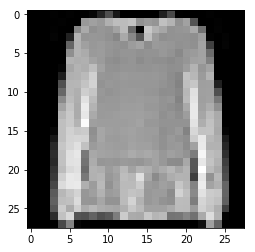

In [8]:
def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    
    image = tf.image.decode_png(example["example"], channels=1)
#     image = tf.image.resize_images(
#         image, [metadata["image_height"] // 8, metadata["image_width"] // 8])
    image = tf.image.per_image_standardization(image)
    
    label = tf.one_hot(example["label"], len(metadata["labels"]))
    
    return image, label

def create_dataset(files, batch_size, num_classes):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(parse_one_example)
    dataset = dataset.map(parse_one_example, num_parallel_calls=8)
    dataset.cache("tensorflow.cache")
    dataset = dataset.shuffle(8 * num_classes)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

training_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["train_examples_name"])],
    params["batch_size"], len(metadata["labels"]))
test_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["test_examples_name"])],
    params["batch_size"], len(metadata["labels"]))

# # Display the first image of a batch as a check
examples, labels = training_dataset.make_one_shot_iterator().get_next()

# Non Eager Mode
with tf.Session() as sess:
    first_image = sess.run(examples)[0]

# Eager Mode
# first_image = examples[0].numpy()
    
print("First image shape:", first_image.shape)
plt.imshow(first_image.reshape(first_image.shape[0], first_image.shape[1]), cmap="gray")

## Model and Train

Copied directly from googles [MNIST on Keras](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) hello world which achieves very high accuracy on MNIST...not so much here...

In [9]:
def create_model(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=input_shape, name="input")

    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(input_layer)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    output_layer = tf.keras.layers.Dense(output_shape, activation="softmax", name="output")(x)
        
    return tf.keras.Model(inputs=input_layer, outputs=output_layer)

model = create_model(input_shape=(first_image.shape[0], first_image.shape[1], 1),
                     output_shape=len(metadata["labels"]))


if os.environ.get("DEBUG"):
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'],
                  optimizer=tf.train.AdadeltaOptimizer())
else:
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'],
                  optimizer=tf.train.AdadeltaOptimizer(),
                  distribute=tf.contrib.distribute.MirroredStrategy())

model.summary()


# Train using multiple GPUS: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/distribute
model.fit(training_dataset, epochs=debug(1, 10), verbose=1, 
          steps_per_epoch=debug(10, metadata["num_train_examples"] // params["batch_size"]))

score = model.evaluate(test_dataset, steps=1, verbose=1)
print("Test loss", score[0], "accuracy:", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
__________